### Transfer Learning and Hyperparameter Tuning with Xception using Adam

In [1]:
! pip install tensorflow
! pip install matplotlib
! pip install numpy
! pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.1 MB/s 
     |████████████████████████████████| 1.6 MB 30.3 MB/s 


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!ls "/content/drive/My Drive/data/FMD/image"

fabric	foliage  glass	leather  metal	paper  plastic	stone  water  wood


In [4]:
!ls "/content/drive/My Drive/data/FMD/test"

fabric	foliage  glass	leather  metal	paper  plastic	stone  water  wood


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

Data download and preprocessing

In [6]:
materials = ['fabric','foliage','glass','leather','metal','paper','plastic','stone','water','wood']
path_to_folder = "/content/drive/My Drive/data/FMD/image/"

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=path_to_folder,
    labels='inferred',
    label_mode='categorical',
    class_names=materials,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset='training'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=path_to_folder,
    labels='inferred',
    label_mode='categorical',
    class_names=materials,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset='validation'
)

Found 2000 files belonging to 10 classes.
Using 1400 files for training.
Found 2000 files belonging to 10 classes.
Using 600 files for validation.


In [7]:
train_dataset.class_names

['fabric',
 'foliage',
 'glass',
 'leather',
 'metal',
 'paper',
 'plastic',
 'stone',
 'water',
 'wood']

In [8]:
# get test dataset
path_to_test = "/content/drive/My Drive/data/FMD/test"
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=path_to_test,
    labels='inferred',
    label_mode='categorical',
    class_names=materials,
    batch_size=4,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=42,
    validation_split=None
)

Found 30 files belonging to 10 classes.


In [9]:
# configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
# data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

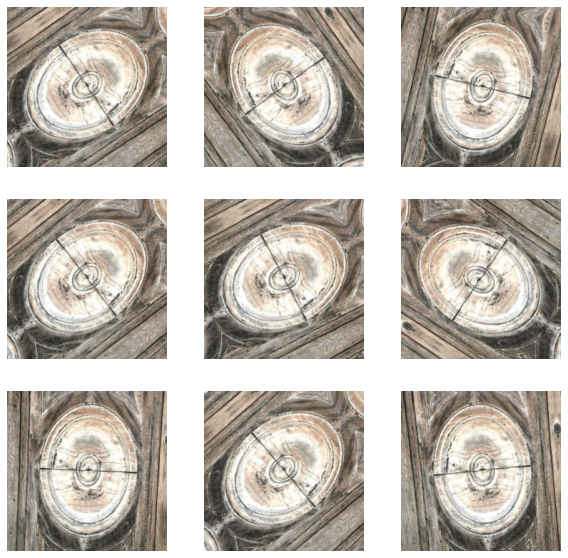

In [11]:
# visualise some of the FMD data
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Hyperparameter tuning using the base HyperModel class

In [12]:
# Create the base model from the pre-trained model Xception
IMG_SHAPE = IMG_SIZE + (3,)
base_xception = tf.keras.applications.xception.Xception(
    include_top=False, # for transfer learning, set to False
    weights='imagenet',
    input_shape=IMG_SHAPE,
)

83683744/83683744 [==============================] - 3s 0us/step


In [13]:
# Freeze convolutional base to use as a feature extractor
base_xception.trainable = False

In [14]:
# Let's take a look at the base model architecture
base_xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [15]:
# To generate predictions from the block of features,
# average over the spatial 3x3 spatial locations using GlobalAveragePooling2D
# to convert features to a single 2048-element vector per image
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_xception(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [16]:
# Apply Dense layer to convert features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(10) # 10 classes
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


Define the hypermodel

In [17]:
def model_builder(hp):
    
    hp_units = hp.Choice('units', [16, 32, 64, 128, 256, 512, 1024])
    hp_lr = hp.Choice('lr', [1e-2, 1e-3, 1e-4])
    hp_ratio1 = hp.Choice('ratio1', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    hp_ratio2 = hp.Choice('ratio2', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    hp_activation = hp.Choice('activation', ['relu', 'elu'])

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.xception.preprocess_input(x)
    x = base_xception(x, training=False) # set training=False due to BatchNormalization layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(hp_ratio1)(x)
    x = tf.keras.layers.Dense(units=hp_units, activation=hp_activation)(x)
    x = tf.keras.layers.Dropout(hp_ratio2)(x)
    outputs = tf.keras.layers.Dense(10)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

Instantiate the tuner and perform hypertuning

In [18]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=15,
    directory="/content/drive/My Drive/data/FMD/",
    project_name='xception_hp_adam'
)

In [19]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [20]:
tuner.search(train_dataset, epochs=50,validation_data=validation_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 02m 10s]
val_accuracy: 0.8516666889190674

Best val_accuracy So Far: 0.8516666889190674
Total elapsed time: 00h 30m 23s


In [21]:
print(best_hps.get('units'))
print(best_hps.get('lr'))
print(best_hps.get('ratio1'))
print(best_hps.get('ratio2'))
print(best_hps.get('activation'))

1024
0.001
0.1
0.6
elu


Train the model with the optimal hyperparameters

In [22]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/data/FMD/saved_models/xception_adam/best_xception_adam_hypertune_gan.h5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max",
    save_weights_only=False, # save the whole model,
    save_freq="epoch"
)

In [23]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[stop_early, model_checkpoint_callback])

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.4501 - accuracy: 0.5800
Epoch 1: val_accuracy improved from -inf to 0.78000, saving model to /content/drive/My Drive/data/FMD/saved_models/xception_adam/best_xception_adam_hypertune_gan.h5
44/44 [==============================] - 15s 266ms/step - loss: 1.4501 - accuracy: 0.5800 - val_loss: 0.7527 - val_accuracy: 0.7800
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 0.7942 - accuracy: 0.7443
Epoch 2: val_accuracy improved from 0.78000 to 0.78833, saving model to /content/drive/My Drive/data/FMD/saved_models/xception_adam/best_xception_adam_hypertune_gan.h5
44/44 [==============================] - 10s 226ms/step - loss: 0.7942 - accuracy: 0.7443 - val_loss: 0.6990 - val_accuracy: 0.7883
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.7857
Epoch 3: val_accuracy improved from 0.78833 to 0.81667, saving model to /content/drive/My Drive/data/FMD/saved_models/xce

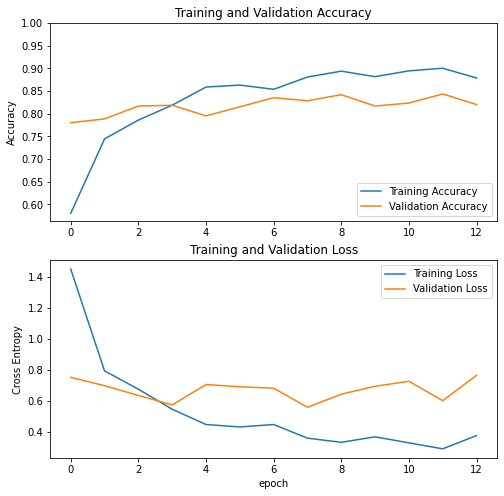

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 12


In [26]:
# Re-instate the hypermodel and train it with the optimal number of epochs
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset)

Epoch 1/12
44/44 [==============================] - 13s 231ms/step - loss: 1.5080 - accuracy: 0.5379 - val_loss: 0.7581 - val_accuracy: 0.7700
Epoch 2/12
44/44 [==============================] - 10s 214ms/step - loss: 0.8099 - accuracy: 0.7457 - val_loss: 0.6929 - val_accuracy: 0.7883
Epoch 3/12
44/44 [==============================] - 10s 214ms/step - loss: 0.6239 - accuracy: 0.8021 - val_loss: 0.6149 - val_accuracy: 0.8067
Epoch 4/12
44/44 [==============================] - 10s 215ms/step - loss: 0.5067 - accuracy: 0.8321 - val_loss: 0.6633 - val_accuracy: 0.7933
Epoch 5/12
44/44 [==============================] - 10s 215ms/step - loss: 0.4843 - accuracy: 0.8464 - val_loss: 0.6207 - val_accuracy: 0.8283
Epoch 6/12
44/44 [==============================] - 10s 214ms/step - loss: 0.3859 - accuracy: 0.8793 - val_loss: 0.6820 - val_accuracy: 0.8067
Epoch 7/12
44/44 [==============================] - 9s 212ms/step - loss: 0.4255 - accuracy: 0.8607 - val_loss: 0.5487 - val_accuracy: 0.8250


In [27]:
eval_result = hypermodel.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 5s 365ms/step - loss: 1.1629 - accuracy: 0.7667
[test loss, test accuracy]: [1.1628690958023071, 0.7666666507720947]


Continue to do hypertuning for fine-tuning of the base model

In [28]:
# unfreeze top layers of the model
base_xception.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_xception.layers))

Number of layers in the base model:  132


In [30]:
def model_builder_finetune(hp):
    
    # Fine-tune from this layer onwards
    hp_fine_tune_at = hp.Int('fine_tune_at', min_value=90, max_value=130, step=10)
    hp_lr = hp.Choice('lr_fine_tune', [1e-2, 1e-3, 1e-4])

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_xception.layers[:hp_fine_tune_at]:
      layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

In [31]:
tuner_finetune = kt.Hyperband(
    model_builder_finetune,
    objective='val_accuracy',
    max_epochs=20,
    directory="/content/drive/My Drive/data/FMD/",
    project_name='xception_hp_adam_ft'
)

In [32]:
tuner_finetune.search(train_dataset, 
             epochs=50,
             validation_data=validation_dataset, 
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner_finetune.get_best_hyperparameters(num_trials=1)[0]

Trial 20 Complete [00h 01m 38s]
val_accuracy: 0.0949999988079071

Best val_accuracy So Far: 0.8633333444595337
Total elapsed time: 00h 25m 10s


In [33]:
print(best_hps.get('fine_tune_at'))
print(best_hps.get('lr_fine_tune'))

120
0.0001


In [34]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner_finetune.hypermodel.build(best_hps)
initial_epochs = history.epoch[-1]
ft_epochs = 50
total_epochs = initial_epochs + ft_epochs
history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1],validation_data=validation_dataset, callbacks=[stop_early, model_checkpoint_callback])

Epoch 13/62
44/44 [==============================] - ETA: 0s - loss: 2.3086 - accuracy: 0.1036
Epoch 13: val_accuracy did not improve from 0.84333
44/44 [==============================] - 13s 227ms/step - loss: 2.3086 - accuracy: 0.1036 - val_loss: 2.3101 - val_accuracy: 0.0900
Epoch 14/62
44/44 [==============================] - ETA: 0s - loss: 2.3151 - accuracy: 0.0964
Epoch 14: val_accuracy did not improve from 0.84333
44/44 [==============================] - 9s 211ms/step - loss: 2.3151 - accuracy: 0.0964 - val_loss: 2.3096 - val_accuracy: 0.0900
Epoch 15/62
44/44 [==============================] - ETA: 0s - loss: 2.3119 - accuracy: 0.1021
Epoch 15: val_accuracy did not improve from 0.84333
44/44 [==============================] - 10s 214ms/step - loss: 2.3119 - accuracy: 0.1021 - val_loss: 2.3084 - val_accuracy: 0.0883
Epoch 16/62
44/44 [==============================] - ETA: 0s - loss: 2.3160 - accuracy: 0.1050
Epoch 16: val_accuracy did not improve from 0.84333
44/44 [==========

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

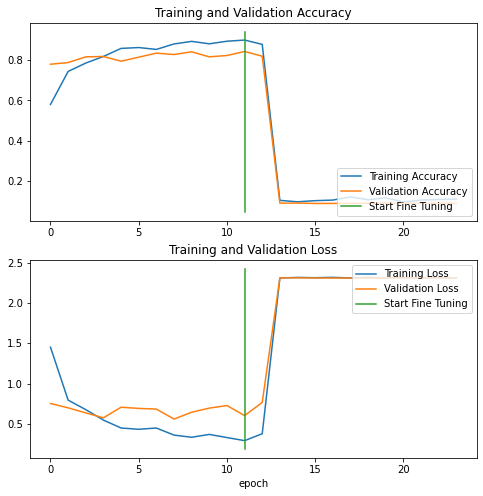

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
val_acc_per_epoch_ft = history_fine.history['val_accuracy']
best_epoch_ft = val_acc_per_epoch_ft.index(max(val_acc_per_epoch_ft)) + 1
print('Best epoch: %d' % (best_epoch_ft,))

Best epoch: 1


In [38]:
# Re-instate the hypermodel and train it with the optimal number of epochs
hypermodel_ft = tuner_finetune.hypermodel.build(best_hps)

# Retrain the model
hypermodel_ft.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset)

Epoch 1/12
44/44 [==============================] - 13s 231ms/step - loss: 2.3145 - accuracy: 0.0957 - val_loss: 2.3074 - val_accuracy: 0.0883
Epoch 2/12
44/44 [==============================] - 10s 214ms/step - loss: 2.3087 - accuracy: 0.1021 - val_loss: 2.3070 - val_accuracy: 0.0883
Epoch 3/12
44/44 [==============================] - 10s 215ms/step - loss: 2.3164 - accuracy: 0.0993 - val_loss: 2.3071 - val_accuracy: 0.0883
Epoch 4/12
44/44 [==============================] - 10s 215ms/step - loss: 2.3177 - accuracy: 0.1007 - val_loss: 2.3074 - val_accuracy: 0.0883
Epoch 5/12
44/44 [==============================] - 10s 214ms/step - loss: 2.3138 - accuracy: 0.1079 - val_loss: 2.3072 - val_accuracy: 0.0900
Epoch 6/12
44/44 [==============================] - 10s 213ms/step - loss: 2.3108 - accuracy: 0.1014 - val_loss: 2.3071 - val_accuracy: 0.0883
Epoch 7/12
44/44 [==============================] - 9s 212ms/step - loss: 2.3091 - accuracy: 0.1107 - val_loss: 2.3070 - val_accuracy: 0.0883


In [39]:
eval_result_ft = hypermodel_ft.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result_ft)

8/8 [==============================] - 1s 92ms/step - loss: 2.3033 - accuracy: 0.1000
[test loss, test accuracy]: [2.3033411502838135, 0.10000000149011612]


In [40]:
saved_xception = tf.keras.models.load_model("/content/drive/My Drive/data/FMD/saved_models/xception_adam/best_xception_adam_hypertune_gan.h5")

In [41]:
eval = saved_xception.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval)

8/8 [==============================] - 2s 92ms/step - loss: 1.0317 - accuracy: 0.8000
[test loss, test accuracy]: [1.0317025184631348, 0.800000011920929]
